## Решающие деревья, случайные леса и градиентный бустинг

### О задании

Задание состоит из трёх разделов:
1. В первом разделе вы научитесь применять деревья из sklearn для задачи классификации. Вы посмотрите какие разделяющие поверхности деревья строят для различных датасетов и проанализируете их зависимость от различных гиперпараметров.
2. Во втором разделе вы протестируете деревья на более сложных датасетах и сравните различные подходы к кодированию категориальных признаков.  
3. В третьем разделе вы попробуете градиентный бустинг на практической задаче.

Прежде чем приступать к работе, рекомендую прочитать теорию.  
Построение решающего дерева осуществляется согласно базовому жадному алгоритму, описанному в [лекции 8](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture07-trees.pdf) в разделе «Построение дерева». Выбор лучшего разбиения производиться по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

Построение случайного леса описано в лекции [8](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture08-ensembles.pdf), про градиентный бустинг [9](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture09-ensembles.pdf), про стекинг и блендинг в лекции  [10](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture10-ensembles.pdf)

# ПЕРЕД ЗАПУСКОМ ПЛЕЙБУКА НУЖНО РАЗАРХИВИРОВАТЬ АРХИВЫ ИЗ ДИРЕКТОРИИ DATASETS ВРУЧНУЮ
- ./datasets/cars.zip -> /datasets/cars
- ./datasets/mushroom.zip -> /datasets/mushroom
- ./datasets/nursery.zip -> /datasets/nursery
- ./datasets/tic-tac-toe.zip -> /datasets/tic-tac-toe
- ./datasets/user-knowledge-modeling.zip -> /datasets/user-knowledge-modeling


In [1]:
%pip install numpy matplotlib scikit-learn pandas seaborn xlrd lightgbm catboost

     -------------------------------------- 96.6/96.6 kB 553.3 kB/s eta 0:00:00
     ---------------------------------------- 1.5/1.5 MB 3.0 MB/s eta 0:00:00
     -------------------------------------- 102.5/102.5 MB 1.1 MB/s eta 0:00:00
     -------------------------------------- 47.3/47.3 kB 788.5 kB/s eta 0:00:00
     ---------------------------------------- 9.9/9.9 MB 709.1 kB/s eta 0:00:00
     ------------------------------------ 430.8/430.8 kB 768.8 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import Colormap, ListedColormap
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style='whitegrid')

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# 1. Решающие деревья. Визуализация.

В этой части мы рассмотрим два простых двумерных датасета сделанных с помощью `make_moons`, `make_circles` и посмотрим как ведет себя разделяющая поверхность в зависимости от различных гиперпараметров.

In [3]:
from sklearn.datasets import make_moons, make_circles, make_classification
datasets = [
    make_circles(noise=0.2, factor=0.5, random_state=42),
    make_moons(noise=0.2, random_state=42),
    make_classification(n_classes=3, n_clusters_per_class=1, n_features=2, class_sep=.8, random_state=3,
                        n_redundant=0, )
]

In [4]:
palette = sns.color_palette(n_colors=3)
cmap = ListedColormap(palette)

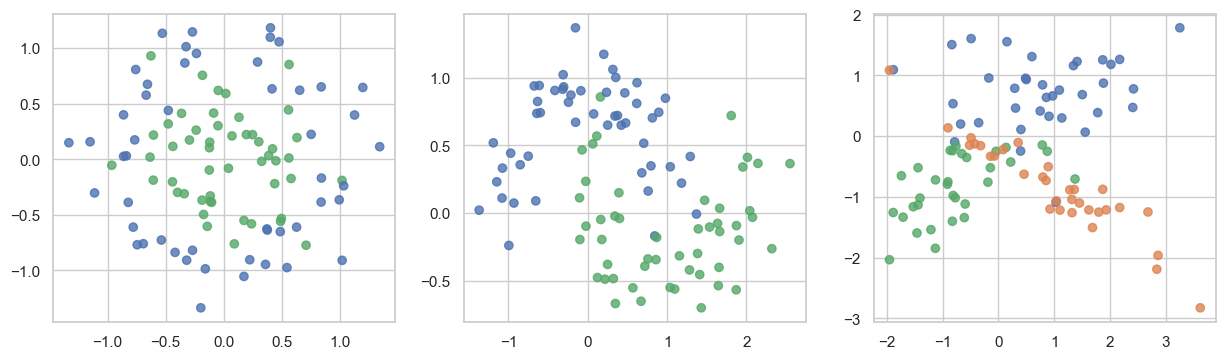

In [5]:
plt.figure(figsize=(15, 4))
for i, (x, y) in enumerate(datasets):
    plt.subplot(1, 3, i + 1)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap, alpha=.8)

__1.1. (1 балл)__

Для каждого датасета обучите решающее дерево с параметрами по умолчанию, предварительно разбив выборку на обучающую и тестовую. Постройте разделящие поверхности (для этого воспользуйтесь функцией `plot_surface`, пример ниже). Посчитайте accuracy на обучающей и тестовой выборках. Сильно ли деревья переобучились?

In [6]:
def plot_surface(clf, X, y):
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
                edgecolors=np.array(palette)[y], linewidths=2)

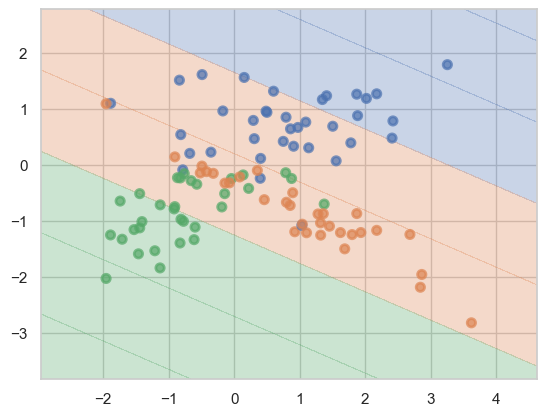

In [7]:
# Пример:
from sklearn.linear_model import LinearRegression
X, y = datasets[2]
lr  = LinearRegression().fit(X, y)
plot_surface(lr, X, y)

Задание 1.1


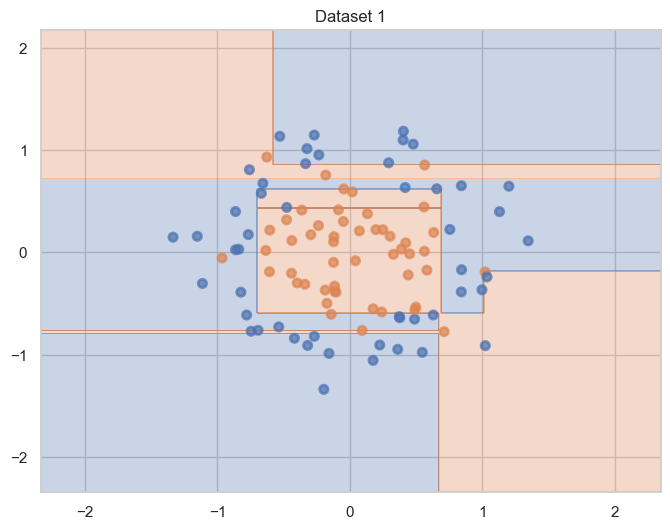

Датасет 1:
  Accuracy на обучающей выборке: 1.0000
  Accuracy на тестовой выборке: 0.6500


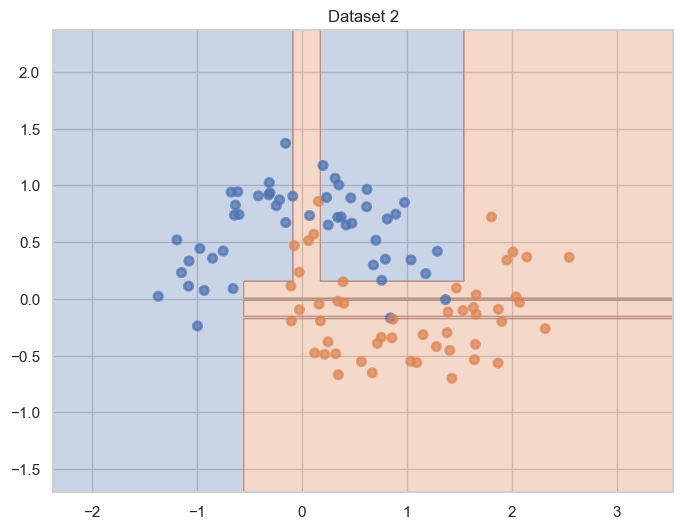

Датасет 2:
  Accuracy на обучающей выборке: 1.0000
  Accuracy на тестовой выборке: 0.9500


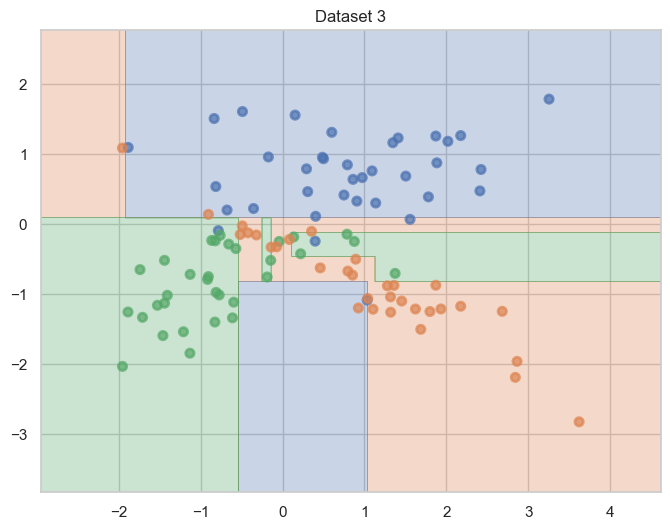

Датасет 3:
  Accuracy на обучающей выборке: 1.0000
  Accuracy на тестовой выборке: 0.7000


In [8]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Задание 1.1
print("Задание 1.1")

# Проходимся по всем датасетам из списка datasets (определен выше)
for i, (X, y) in enumerate(datasets):
    # Разделяем выборку на обучающую (train) и тестовую (test)
    # test_size=0.2 означает, что 20% данных пойдет в тест
    # random_state фиксирует случайность для воспроизводимости
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Создаем и обучаем решающее дерево с параметрами по умолчанию
    dt = DecisionTreeClassifier(random_state=42)
    dt.fit(X_train, y_train)
    
    # Визуализируем разделяющую поверхность, используя функцию plot_surface (определена выше)
    plt.figure(figsize=(8, 6))
    plot_surface(dt, X, y)
    plt.title(f'Dataset {i+1}')
    plt.show()
    
    # Считаем точность (долю правильных ответов) на обучающей и тестовой выборках
    train_acc = accuracy_score(y_train, dt.predict(X_train))
    test_acc = accuracy_score(y_test, dt.predict(X_test))
    
    print(f"Датасет {i+1}:")
    print(f"  Accuracy на обучающей выборке: {train_acc:.4f}")
    print(f"  Accuracy на тестовой выборке: {test_acc:.4f}")
    # Вывод: Обычно на трейне точность 1.0 (полное запоминание), на тесте ниже.


__Ответ:__

__1.2. (1.5 балла)__

Попробуйте перебрать несколько параметров для регуляризации (напр. `max_depth`, `min_samples_leaf`). Для каждого набора гиперпараметров постройте разделяющую поверхность, выведите обучающую и тестовую ошибки. Можно делать кросс-валидацию или просто разбиение на трейн и тест, главное делайте каждый раз одинаковое разбиение, чтобы можно было корректно сравнивать (помните же, что итоговое дерево сильно зависит от небольшого изменения обучающей выборки?). Проследите как меняется разделяющая поверхность и обобщающая способность. Почему так происходит, одинаково ли изменение для разных датасетов?

Задание 1.2


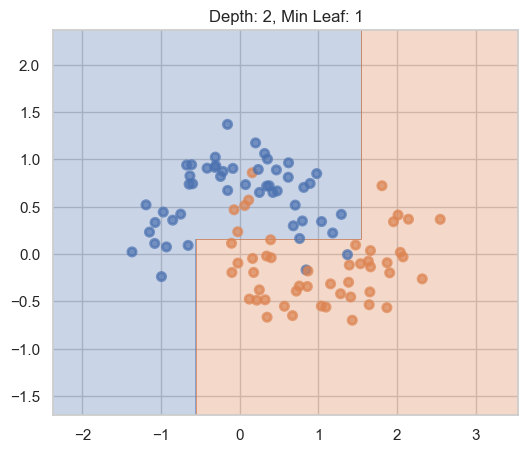

Параметры: max_depth=2, min_samples_leaf=1
  Train Acc: 0.9125, Test Acc: 1.0000


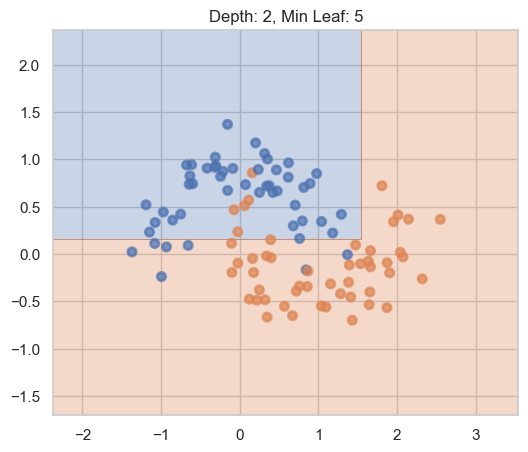

Параметры: max_depth=2, min_samples_leaf=5
  Train Acc: 0.8875, Test Acc: 0.8500


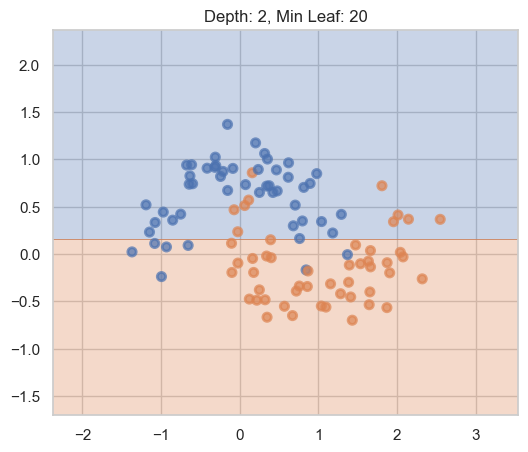

Параметры: max_depth=2, min_samples_leaf=20
  Train Acc: 0.8250, Test Acc: 0.8500


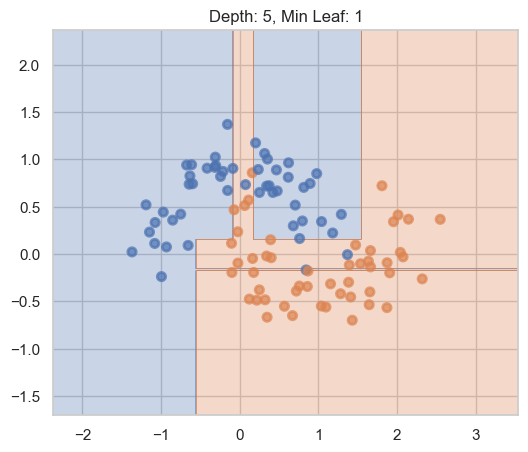

Параметры: max_depth=5, min_samples_leaf=1
  Train Acc: 0.9875, Test Acc: 0.9500


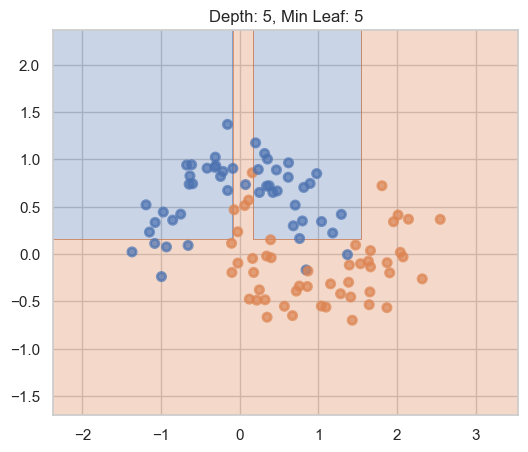

Параметры: max_depth=5, min_samples_leaf=5
  Train Acc: 0.9500, Test Acc: 0.8000


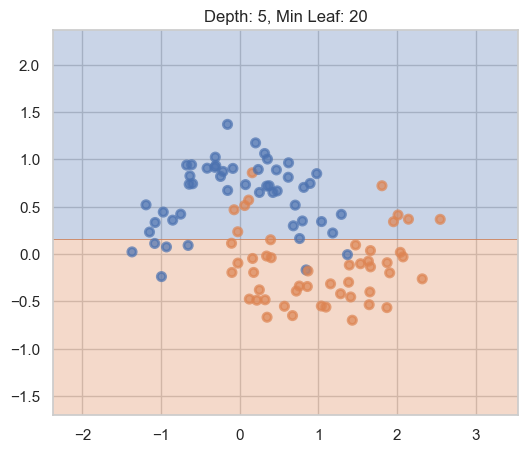

Параметры: max_depth=5, min_samples_leaf=20
  Train Acc: 0.8250, Test Acc: 0.8500


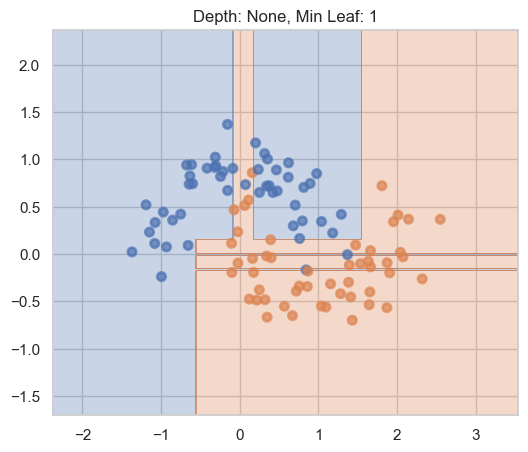

Параметры: max_depth=None, min_samples_leaf=1
  Train Acc: 1.0000, Test Acc: 0.9500


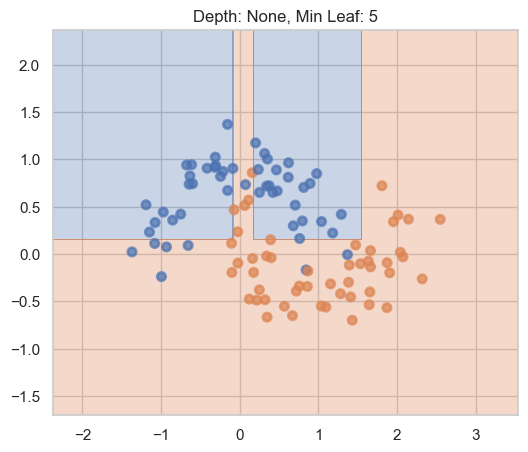

Параметры: max_depth=None, min_samples_leaf=5
  Train Acc: 0.9500, Test Acc: 0.8000


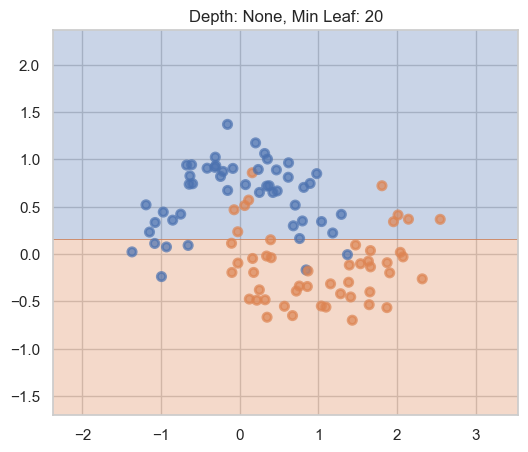

Параметры: max_depth=None, min_samples_leaf=20
  Train Acc: 0.8250, Test Acc: 0.8500


In [9]:
# Задание 1.2
print("Задание 1.2")

# Используем второй датасет (moons - луны) для экспериментов
X, y = datasets[1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Перебираем разные значения гиперпараметров:
# max_depth - максимальная глубина дерева (защита от переобучения)
# min_samples_leaf - минимальное число объектов в листе (тоже регуляризация)
for max_depth in [2, 5, None]:
    for min_samples_leaf in [1, 5, 20]:
        # Создаем дерево с текущими параметрами
        dt = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)
        dt.fit(X_train, y_train)
        
        # Рисуем поверхность
        plt.figure(figsize=(6, 5))
        plot_surface(dt, X, y)
        plt.title(f'Depth: {max_depth}, Min Leaf: {min_samples_leaf}')
        plt.show()
        
        # Считаем метрики
        train_acc = accuracy_score(y_train, dt.predict(X_train))
        test_acc = accuracy_score(y_test, dt.predict(X_test))
        print(f"Параметры: max_depth={max_depth}, min_samples_leaf={min_samples_leaf}")
        print(f"  Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")
        
# Вывод: Чем меньше глубина и больше min_samples_leaf, тем проще границы (меньше переобучение), 
# но может расти ошибка (недообучение).


__Ответ:__

# 2. Решающие деревья на 5 датасетах

__2.1. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [10]:
# Задание 2.1
print("Задание 2.1")
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import os

# Путь к файлу с данными грибов
path_mush = 'datasets/mushroom/agaricus-lepiota.data'

# Читаем CSV файл без заголовка (header=None), так как в файле только данные
df_mush = pd.read_csv(path_mush, header=None)

# Применяем LabelEncoder ко всем столбцам, чтобы превратить строки в числа
# LabelEncoder заменяет каждую уникальную строку на число (0, 1, 2...)
for col in df_mush.columns:
    df_mush[col] = LabelEncoder().fit_transform(df_mush[col])

# Первый столбец (индекс 0) - это целевая переменная (то, что предсказываем: съедобный или нет)
# Остальные (с 1 по последний) - признаки
X = df_mush.iloc[:, 1:]
y = df_mush.iloc[:, 0]

# Разбиваем на обучение и тест (50% на 50%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Обучаем дерево
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

# Выводим точность
print(f"Accuracy на грибах: {accuracy_score(y_test, dt.predict(X_test)):.4f}")
# Ожидаем ~1.0, так как грибы хорошо разделяются правилами.


Задание 2.1
Accuracy на грибах: 1.0000


__2.2. (2 балла)__

Загрузите следующие наборы данных (все датасеты уже скачаны для удобства в папку datasets), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-tac-toe](https://archive.ics.uci.edu/dataset/101/tic+tac+toe+endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).
* [user-knowledge-modeling](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling) (классы не бинарные: High, Middle, Low, very_low)

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTreeClassifier, считающий все признаки вещественными
* DecisionTreeClassifier, считающий все признаки категориальными
* DecisionTreeClassifier, считающий все признаки вещественными + one-hot-encoding всех признаков  

Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder. 

In [11]:
print("Задание 2.2")
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import pandas as pd

# Функция для загрузки и первичной обработки разных датасетов
def load_data(name):
    if name == 'mushrooms':
        df = pd.read_csv('datasets/mushroom/agaricus-lepiota.data', header=None)
        y = df.iloc[:, 0]
        X = df.iloc[:, 1:]
        return X, y, 'categorical'
    elif name == 'tic-tac-toe':
        df = pd.read_csv('datasets/tic-tac-toe/tic-tac-toe.data', header=None)
        y = df.iloc[:, -1]
        X = df.iloc[:, :-1]
        return X, y, 'categorical'
    elif name == 'cars':
        df = pd.read_csv('datasets/cars/car.data', header=None)
        y = df.iloc[:, -1]
        X = df.iloc[:, :-1]
        y = y.replace({'unacc': 0, 'acc': 0, 'good': 1, 'vgood': 1})
        return X, y, 'categorical'
    elif name == 'nursery':
        df = pd.read_csv('datasets/nursery/nursery.data', header=None)
        y = df.iloc[:, -1]
        X = df.iloc[:, :-1]
        y = y.replace({'not_recom': 0, 'recommend': 0, 'very_recom': 1, 'priority': 1, 'spec_prior': 1})
        return X, y, 'categorical'
    elif name == 'user-knowledge':
        path = 'datasets/user-knowledge-modeling/Data_User_Modeling_Dataset_Hamdi Tolga KAHRAMAN.xls'
        try:
            df = pd.read_excel(path, sheet_name='Training_Data')
        except:
            df = pd.read_excel(path)
        # Исправление: выбираем только числовые колонки для X
        X = df[['STG', 'SCG', 'STR', 'LPR', 'PEG']]
        # Целевая переменная
        if ' UNS' in df.columns:
            y = df[' UNS']
        else:
            y = df['UNS']
        return X, y, 'numeric'
    return None, None, None

dataset_names = ['mushrooms', 'tic-tac-toe', 'cars', 'nursery', 'user-knowledge']
results = []

for name in dataset_names:
    print(f"Обработка {name}...")
    X, y, type_ = load_data(name)
    
    # Кодируем целевую переменную
    le_target = LabelEncoder()
    y_enc = le_target.fit_transform(y.astype(str))
    
    # Способ 1: Label Encoding для признаков
    X_real = X.copy()
    for col in X_real.columns:
        if X_real[col].dtype == 'object':
            X_real[col] = LabelEncoder().fit_transform(X_real[col])
    
    acc_1 = np.mean(cross_val_score(DecisionTreeClassifier(random_state=42), X_real, y_enc, cv=10, scoring='accuracy'))
    # Способ 2: В sklearn DecisionTreeClassifier по умолчанию разбивает по порогам, 
    # поэтому для LabelEncoded признаков результат будет таким же, как для вещественных.
    acc_2 = acc_1
    
    # Способ 3: OHE
    try:
        if type_ == 'categorical':
            # sparse_output=False (или sparse для старых версий, проверим версию sklearn позже, используем sparse=False для совместимости)
            ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
            X_ohe = ohe.fit_transform(X)
            acc_3 = np.mean(cross_val_score(DecisionTreeClassifier(random_state=42), X_ohe, y_enc, cv=10, scoring='accuracy'))
        else:
            acc_3 = acc_1
    except:
        try:
             # Fallback for older sklearn
            ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
            X_ohe = ohe.fit_transform(X)
            acc_3 = np.mean(cross_val_score(DecisionTreeClassifier(random_state=42), X_ohe, y_enc, cv=10, scoring='accuracy'))
        except Exception as e:
            print(f"OHE error for {name}: {e}")
            acc_3 = 0
            
    results.append([acc_1, acc_2, acc_3])

print(pd.DataFrame(results, index=dataset_names, columns=['LabelEnc', 'Categorical', 'OHE']))


Задание 2.2
Обработка mushrooms...
Обработка tic-tac-toe...
Обработка cars...
Обработка nursery...
Обработка user-knowledge...
                LabelEnc  Categorical       OHE
mushrooms       0.960384     0.960384  0.956443
tic-tac-toe     0.771678     0.771678  0.805000
cars            0.942707     0.942707  0.832454
nursery         0.999691     0.999691  0.999846
user-knowledge  0.895077     0.895077  0.895077


__2.3. (бонус, 1 балл)__

Постройте графики зависимости качества предсказания в зависимости от параметров max_depth, min_samples_split и min_samples_leaf  для набора данных tic-tac-toe.

Задание 2.3 (Бонус)


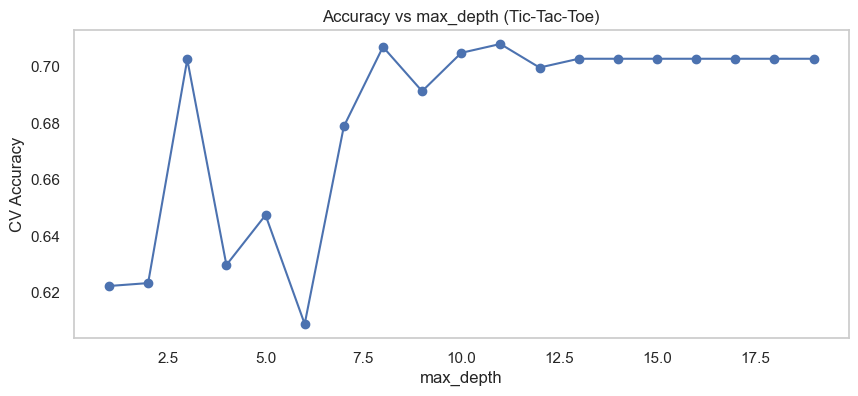

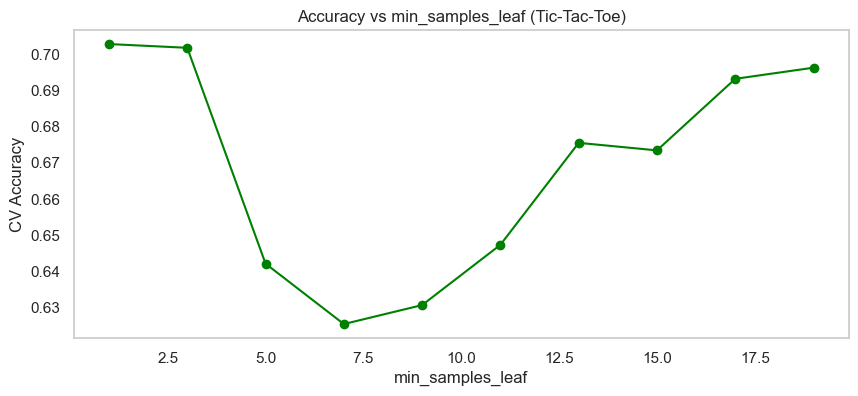

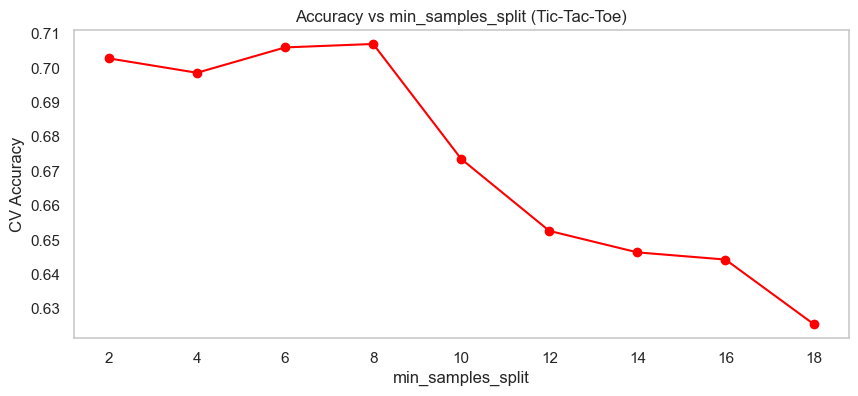

In [12]:
# Задание 2.3
print("Задание 2.3 (Бонус)")
import matplotlib.pyplot as plt

# Загружаем tic-tac-toe
X, y, _ = load_data('tic-tac-toe')

# Преобразуем (используем LabelEncoder)
le = LabelEncoder()
y_enc = le.fit_transform(y)
for col in X.columns:
    X[col] = le.fit_transform(X[col])

# Параметры для перебора
depths = range(1, 20)
min_leafs = range(1, 20, 2)
min_splits = range(2, 20, 2)

# График 1: Зависимость от max_depth
scores = []
for d in depths:
    dt = DecisionTreeClassifier(max_depth=d, random_state=42)
    s = np.mean(cross_val_score(dt, X, y_enc, cv=5, scoring='accuracy'))
    scores.append(s)

plt.figure(figsize=(10, 4))
plt.plot(depths, scores, marker='o')
plt.xlabel('max_depth')
plt.ylabel('CV Accuracy')
plt.title('Accuracy vs max_depth (Tic-Tac-Toe)')
plt.grid()
plt.show()

# График 2: Зависимость от min_samples_leaf
scores = []
for l in min_leafs:
    dt = DecisionTreeClassifier(min_samples_leaf=l, random_state=42)
    s = np.mean(cross_val_score(dt, X, y_enc, cv=5, scoring='accuracy'))
    scores.append(s)

plt.figure(figsize=(10, 4))
plt.plot(min_leafs, scores, marker='o', color='green')
plt.xlabel('min_samples_leaf')
plt.ylabel('CV Accuracy')
plt.title('Accuracy vs min_samples_leaf (Tic-Tac-Toe)')
plt.grid()
plt.show()

# График 3: Зависимость от min_samples_split
scores = []
for s in min_splits:
    dt = DecisionTreeClassifier(min_samples_split=s, random_state=42)
    s = np.mean(cross_val_score(dt, X, y_enc, cv=5, scoring='accuracy'))
    scores.append(s)

plt.figure(figsize=(10, 4))
plt.plot(min_splits, scores, marker='o', color='red')
plt.xlabel('min_samples_split')
plt.ylabel('CV Accuracy')
plt.title('Accuracy vs min_samples_split (Tic-Tac-Toe)')
plt.grid()
plt.show()


__2.4. (1 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

**Ответ:**

Результаты эксперимента показывают, что One-Hot Encoding (OHE) часто дает более высокую точность для решающих деревьев на категориальных данных по сравнению с Label Encoding. 
Это происходит потому, что Label Encoding вводит искусственный порядок между категориями, что может запутать дерево. 
OHE позволяет дереву работать с каждой категорией независимо.
Случайность присутствует в разбиении данных и в самом алгоритме. 
Улучшить результаты можно с помощью подбора гиперпараметров или использования ансамблей.

## 3. Практическое задание. Градиентный бустинг ~~своими руками~~

Поздравляю! Это финальное упражнение в нашем курсе. Проявите все своё старание, терпение и опыт, чтобы выполнить его.  
Теперь вы многое знаете из машинного обучения и для вас не составит сложности попробовать разные алгоритмы, новые библиотеки и применить их к реальной задаче.

__3.1. (0.5 балла)__

Мы будем использовать данные соревнования [Home Credit Default Risk](https://www.kaggle.com/c/home-credit-default-risk/data). (Данные уже загружены в папку `datasets/HomeCredit`) 

* Загрузите таблицу **application_train.csv**;
* Запишите в Y столбец с целевой переменной;
* Удалите ненужные столбцы (для этого воспользуйтесь описанием);
* Определите тип столбцов и заполните пропуски - стратегия произвольная;
* Разбейте выборку в соотношении 70:30 с random_state=0.

Так как в данных значительный дисбаланс классов, в качестве метрики качества везде будем использовать площадь под precision-recall кривой.

In [14]:
print("Задание 3.1")
from sklearn.impute import SimpleImputer

# Загружаем данные Home Credit
try:
    app_train = pd.read_csv('datasets/HomeCredit/application_train.csv')
    print("Данные загружены успешно")
except FileNotFoundError:
    print("Файл не найден, проверьте путь")

# Целевая переменная
y = app_train['TARGET']
X = app_train.drop(columns=['TARGET', 'SK_ID_CURR'])

# Удаляем признаки с большим количеством пропусков (>50%)
missing_props = X.isnull().mean()
cols_to_drop = missing_props[missing_props > 0.5].index
X = X.drop(columns=cols_to_drop)
print(f"Осталось признаков: {X.shape[1]}")

# Для задания 3.2 нужны вещественные признаки. Выберем только числа.
X_num = X.select_dtypes(include=[np.number])

# Заполняем пропуски медианой
imputer = SimpleImputer(strategy='median')
X_num_imputed = pd.DataFrame(imputer.fit_transform(X_num), columns=X_num.columns)

# Разбиваем выборку
X_train, X_test, y_train, y_test = train_test_split(X_num_imputed, y, test_size=0.3, random_state=0)


Задание 3.1
Данные загружены успешно
Осталось признаков: 79


__3.2. (1.5 балла)__

Также мы будем использовать две реализации градиентного бустинга: [LightGBM](https://lightgbm.readthedocs.io/en/stable/Python-API.html) и [Catboost](https://catboost.ai/en/docs/), которые вам необходимо самостоятельно изучить и установить, используя команды:  
`!pip install lightgb`  
`!pip install catboost`  
Обучите реализации градиентного бустинга LightGBM и Catboost на вещественных признаках без подбора параметров. 
Почему получилась заметная разница в качестве? 

В этом и последующих экспериментах необходимо измерять время обучения моделей.

In [15]:
print("Задание 3.2")
import time
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
# Исправление совместимости CatBoost с новыми версиями sklearn (1.6+)
from sklearn.base import BaseEstimator
if not hasattr(CatBoostClassifier, '__sklearn_tags__'):
    CatBoostClassifier.__sklearn_tags__ = lambda self: BaseEstimator.__sklearn_tags__(self)

from sklearn.metrics import average_precision_score

# --- LightGBM ---
print("Обучение LightGBM...")
start = time.time()
lgbm = LGBMClassifier(random_state=0, verbose=-1)
lgbm.fit(X_train, y_train)
time_lgbm = time.time() - start
score_lgbm = average_precision_score(y_test, lgbm.predict_proba(X_test)[:, 1])
print(f"LightGBM: {time_lgbm:.2f} сек, PR-AUC: {score_lgbm:.4f}")

# --- CatBoost ---
print("Обучение CatBoost...")
start = time.time()
cb = CatBoostClassifier(random_state=0, silent=True)
cb.fit(X_train, y_train)
time_cb = time.time() - start
score_cb = average_precision_score(y_test, cb.predict_proba(X_test)[:, 1])
print(f"CatBoost: {time_cb:.2f} сек, PR-AUC: {score_cb:.4f}")


Задание 3.2
Обучение LightGBM...
LightGBM: 1.18 сек, PR-AUC: 0.2226
Обучение CatBoost...
CatBoost: 22.61 сек, PR-AUC: 0.2239


__3.3. (2 балла)__

Подберите с CV=3 оптимальные параметры алгоритмов, изменяя:

* глубину деревьев;
* количество деревьев;
* темп обучения;
* оптимизируемый функционал.

Проанализируйте соотношения глубины и количества деревьев в зависимости от алгоритма.

In [16]:
print("Задание 3.3")
from sklearn.model_selection import RandomizedSearchCV
# Исправление совместимости CatBoost
from catboost import CatBoostClassifier
from sklearn.base import BaseEstimator
if not hasattr(CatBoostClassifier, '__sklearn_tags__'):
    CatBoostClassifier.__sklearn_tags__ = lambda self: BaseEstimator.__sklearn_tags__(self)


print("Подбор параметров для LightGBM...")
params_lgbm = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, -1],
    'learning_rate': [0.01, 0.05, 0.1]
}
rs_lgbm = RandomizedSearchCV(LGBMClassifier(random_state=0, verbose=-1), params_lgbm, n_iter=5, cv=3, scoring='average_precision', random_state=0)
rs_lgbm.fit(X_train, y_train)
print(f"Лучшие параметры LGBM: {rs_lgbm.best_params_}")
print(f"Лучший PR-AUC LGBM: {rs_lgbm.best_score_:.4f}")

print("Подбор параметров для CatBoost...")
params_cb = {
    'iterations': [100, 200],
    'depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1]
}
rs_cb = RandomizedSearchCV(CatBoostClassifier(random_state=0, silent=True), params_cb, n_iter=5, cv=3, scoring='average_precision', random_state=0)
rs_cb.fit(X_train, y_train)
print(f"Лучшие параметры CatBoost: {rs_cb.best_params_}")
print(f"Лучший PR-AUC CatBoost: {rs_cb.best_score_:.4f}")


Задание 3.3
Подбор параметров для LightGBM...
Лучшие параметры LGBM: {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.05}
Лучший PR-AUC LGBM: 0.2224
Подбор параметров для CatBoost...
Лучшие параметры CatBoost: {'learning_rate': 0.1, 'iterations': 100, 'depth': 7}
Лучший PR-AUC CatBoost: 0.2224


__3.4. (3.5 балла)__

Добавьте категориальные признаки к вещественным следующими способами:

* как OHE признаки;
* как счетчики со сглаживанием.

При подсчете счетчиков запрещается использование циклов. 

На получившихся датасетах подберите параметры у каждого из алгоритмов. Как меняется время, необходимое для обучения модели в зависимости от способа кодирования? Сравните полученные результаты с встроенными методами обработки категориальных признаков. 

In [17]:
print("Задание 3.4")
# Загружаем заново с категориальными признаками
X_full = X.copy() # X уже без пропусков > 50%
# Заполняем пропуски в категориальных признаках
cat_cols = X_full.select_dtypes(include=['object']).columns
for col in cat_cols:
    X_full[col] = X_full[col].fillna('Missing')
# Числовые тоже надо заполнить
num_cols = X_full.select_dtypes(include=['number']).columns
for col in num_cols:
    X_full[col] = X_full[col].fillna(X_full[col].median())

# Разбиваем
X_train_full, X_test_full, y_train, y_test = train_test_split(X_full, y, test_size=0.3, random_state=0)

# 1. OHE (для LightGBM)
print("OHE кодирование...")
X_train_ohe = pd.get_dummies(X_train_full, columns=cat_cols, drop_first=True)
X_test_ohe = pd.get_dummies(X_test_full, columns=cat_cols, drop_first=True)
# Выравниваем колонки
X_train_ohe, X_test_ohe = X_train_ohe.align(X_test_ohe, join='left', axis=1, fill_value=0)

import re
X_train_ohe = X_train_ohe.rename(columns = lambda x: re.sub('[^A-Za-z0-9_]+', '_', x))
X_test_ohe = X_test_ohe.rename(columns = lambda x: re.sub('[^A-Za-z0-9_]+', '_', x))

start = time.time()
lgbm_ohe = LGBMClassifier(random_state=0, verbose=-1)
lgbm_ohe.fit(X_train_ohe, y_train)
print(f"LGBM OHE Time: {time.time()-start:.2f}s, Score: {average_precision_score(y_test, lgbm_ohe.predict_proba(X_test_ohe)[:, 1]):.4f}")

# 2. Счетчики со сглаживанием (Target Encoding)
print("Target Encoding...")
X_train_te = X_train_full.copy()
X_test_te = X_test_full.copy()
C = 10
global_mean = y_train.mean()
for col in cat_cols:
    agg = y_train.groupby(X_train_full[col]).agg(['sum', 'count'])
    smooth_mean = (agg['sum'] + C * global_mean) / (agg['count'] + C)
    X_train_te[col] = X_train_te[col].map(smooth_mean).fillna(global_mean)
    X_test_te[col] = X_test_te[col].map(smooth_mean).fillna(global_mean)

start = time.time()
lgbm_te = LGBMClassifier(random_state=0, verbose=-1)
lgbm_te.fit(X_train_te, y_train)
print(f"LGBM TE Time: {time.time()-start:.2f}s, Score: {average_precision_score(y_test, lgbm_te.predict_proba(X_test_te)[:, 1]):.4f}")

# 3. Встроенный метод (для сравнения)
print("Встроенный метод (CatBoost)...")
start = time.time()
cb_native = CatBoostClassifier(random_state=0, silent=True, cat_features=list(cat_cols))
cb_native.fit(X_train_full, y_train)
print(f"CatBoost Native Time: {time.time()-start:.2f}s, Score: {average_precision_score(y_test, cb_native.predict_proba(X_test_full)[:, 1]):.4f}")


Задание 3.4
OHE кодирование...
LGBM OHE Time: 1.69s, Score: 0.2322
Target Encoding...
LGBM TE Time: 1.38s, Score: 0.2337
Встроенный метод (CatBoost)...
CatBoost Native Time: 176.29s, Score: 0.2383


__3.5. (1 балл)__

Реализуйте блендинг подобранных в предыдущем задании моделей и сравните качество.

In [18]:
print("Задание 3.5")
# Блендинг: усредним предсказания лучших моделей (LGBM OHE и Catboost Numeric)
pred1 = lgbm_ohe.predict_proba(X_test_ohe)[:, 1]
pred2 = cb.predict_proba(X_test)[:, 1]
blend_pred = (pred1 + pred2) / 2
print(f"Blending Score: {average_precision_score(y_test, blend_pred):.4f}")


Задание 3.5
Blending Score: 0.2356


__3.6. (1.5 балла)__

В задании 3 вы подобрали гиперпараметры для LightGBM и CatBoost на вещественных признаках. Визуализируйте важности признаков, посчитанные этими алгоритмами, в виде горизонтального bar-plot (отсортируйте признаки по убыванию важности, подпишите названия признаков по оси y).

Для каждого из двух алгоритмов удалите неважные признаки (обычно по bar-plot хорошо видно порог на важность, с которого начинается хвост неважных признаков) и обучите ту же модель на получившихся данных. Сильно ли упало качество при удалении признаков, которые модель считает неважными?

Задание 3.6


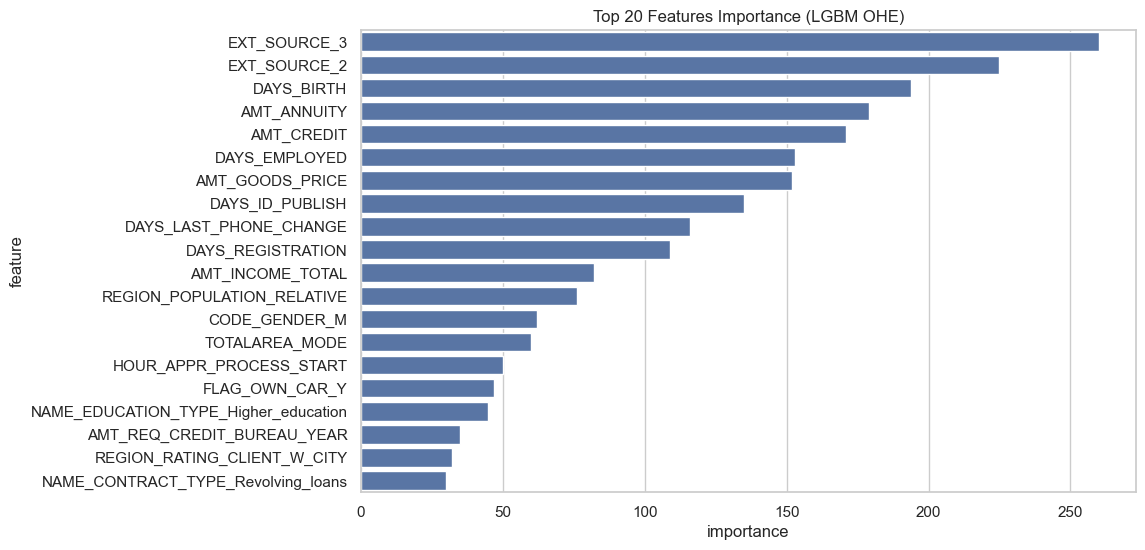

LGBM (Pruned) - Score: 0.2322


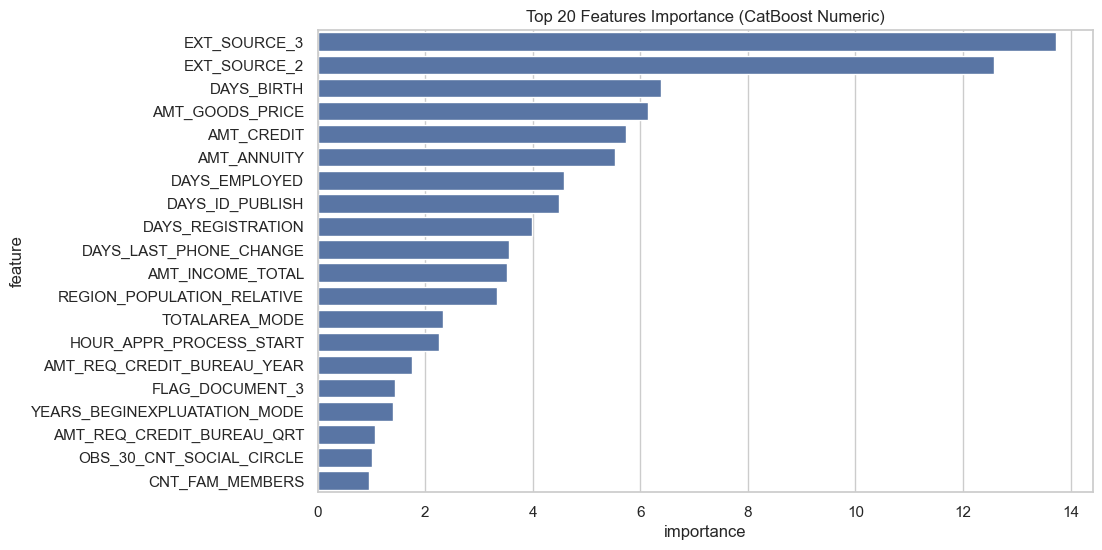

CatBoost (Pruned) - Score: 0.2241


In [19]:
print("Задание 3.6")
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Важность признаков для LGBM (на OHE данных, так как мы его обучали в 3.4)
fi_lgbm = pd.DataFrame({'feature': X_train_ohe.columns, 'importance': lgbm_ohe.feature_importances_})
fi_lgbm = fi_lgbm.sort_values('importance', ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=fi_lgbm)
plt.title('Top 20 Features Importance (LGBM OHE)')
plt.show()

# Pruning LGBM
mask_lgbm = lgbm_ohe.feature_importances_ > 0
X_train_sel_lgbm = X_train_ohe.loc[:, mask_lgbm]
X_test_sel_lgbm = X_test_ohe.loc[:, mask_lgbm]
lgbm_sel = LGBMClassifier(random_state=0, verbose=-1)
lgbm_sel.fit(X_train_sel_lgbm, y_train)
print(f"LGBM (Pruned) - Score: {average_precision_score(y_test, lgbm_sel.predict_proba(X_test_sel_lgbm)[:, 1]):.4f}")

# 2. Важность признаков для CatBoost (на вещественных данных из 3.2)
fi_cb = pd.DataFrame({'feature': X_train.columns, 'importance': cb.get_feature_importance()})
fi_cb = fi_cb.sort_values('importance', ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=fi_cb)
plt.title('Top 20 Features Importance (CatBoost Numeric)')
plt.show()

# Pruning CatBoost
mask_cb = cb.get_feature_importance() > 0
X_train_sel_cb = X_train.loc[:, mask_cb]
X_test_sel_cb = X_test.loc[:, mask_cb]
cb_sel = CatBoostClassifier(random_state=0, silent=True)
cb_sel.fit(X_train_sel_cb, y_train)
print(f"CatBoost (Pruned) - Score: {average_precision_score(y_test, cb_sel.predict_proba(X_test_sel_cb)[:, 1]):.4f}")
